In [ ]:
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset.utils import normalize_epigenomic_data
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
from typing import Tuple
from typing import Optional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers import Nadam
from barplots import barplots
from cache_decorator import Cache



In [ ]:
[cell_line, assembly, window_size] = ['HepG2', 'hg38', 256]

In [ ]:
genome = Genome(assembly)
genome

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

/home/emir/.local/lib/python3.10/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


Human, Homo sapiens, hg38, 2013-12-29, 25 chromosomes

In [ ]:
with open('./features/enhancers_features.pkl', 'rb') as f:
    enhancers_features = pickle.load(file=f)

In [ ]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

### Training sequence methods

In [ ]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 256
) -> MixedSequence:
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 32
) -> MixedSequence:
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 256
) -> MixedSequence:
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Fixed builders

In [ ]:
def build_fixed_ffnn( input_shape: int )->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense( 16, activation="relu")(input_epigenomic_data)
    hidden = Dense( 4, activation="relu")(hidden)
    hidden = Dense( 2, activation="relu")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FFNN"
    )

    ffnn.compile(
        optimizer = SGD(learning_rate=0.5, decay=0.1),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

def build_fixed_cnn( window_size: int )->Tuple[Model, Layer, Layer]:

    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = GlobalAveragePooling1D()(hidden)
    
    hidden = Dropout(rate=0.5)(hidden)
    hidden = Dense(10, activation="relu")(hidden)
    hidden = Dense(10, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.5)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="CNN"
    )

    cnn.compile(
        optimizer = Nadam(lr = 0.002),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn


def build_fixed_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, dummy output, dummy output."""
    
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer = Nadam(lr = 0.002),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn, None, None 


In [ ]:
@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    epochs: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Train the provided Neural Network and returns training history + model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
    epochs: int,
        The max number of epochs to execute
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=epochs,
        verbose=False,
        callbacks=[EarlyStopping(
            monitor="AUPRC",
            mode="max",
            min_delta=0.001,
            patience=5,
            restore_best_weights=True
        ),
        TqdmCallback(1)]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 10

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Create a list to store all the computed performance
all_fixed_performance = []

training_histories = {}
number_of_splits=10

for task, threshold, feature_selection in tqdm(( (active_promoters_vs_inactive_promoters, 1, False), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, True), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, False) ), desc="Tasks"):
    task_name = task.__name__+ (' (FS)' if feature_selection==True else ' (NO FS)')
    print(task_name)
    
    X, y = task(
        cell_line=cell_line,
        assembly = assembly,
        window_size=window_size,
        metric='mean'
    )

    #Labels binarization [enhancers threshold = 0.0; promoters threshold = 1.0]
    y = y > threshold

    # If feature_selection is active dropping not selected features
    if feature_selection:
        X = X.filter(items=enhancers_features, axis=1)

    training_histories[task_name] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm( enumerate(holdouts_generator.split(X, y)), total=number_of_splits, leave=False, desc="Computing holdouts"):
        print('-'*50)
        print(f'Holdout number: {holdout_number}; train_indices: {train_indices}; test_indices: {test_indices}')
        print('-'*50)
        
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        # Training the Neural Networks
        for model, train_sequence, test_sequence, epochs  in tqdm( (
                                                                      (build_fixed_ffnn( input_shape = number_of_features), get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y) , 64 ),
                                                                      (build_fixed_cnn( window_size = window_size), get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y), 100),
                                                                      (build_fixed_mmnn( input_shape = number_of_features, window_size = window_size), get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y), 100)
                                                                 ) ):
            # We compute the model performance
            history, performance = train_model (
                model[0],
                model[0].name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number,
                epochs = epochs
            )
            training_histories[task_name].append(history)
            all_fixed_performance.append(performance)
        
        # Training the Random Forest
        
all_fixed_performance = pd.concat(all_fixed_performance)

Tasks:   0%|          | 0/3 [00:00<?, ?it/s]

active_promoters_vs_inactive_promoters (NO FS)


Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------
Holdout number: 0; train_indices: [74677 19551 56896 ... 24017 53296 24361]; test_indices: [20957 70871 74970 ... 45301 46169 62554]
--------------------------------------------------


2022-06-29 13:58:40.787731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 13:58:40.857439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 13:58:40.857620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 13:58:40.858878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

KeyboardInterrupt: 

In [ ]:
with open('./features/all_fixed_performance.pkl', 'rb') as f:
    all_fixed_performance = pickle.load(file=f)
df = all_fixed_performance.loc[all_fixed_performance["model_name"] != "RF"]

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

[(<Figure size 3000x480 with 3 Axes>,
  array([<AxesSubplot:title={'center':'active enhancers VS inactive enhancers (FS)'}, xlabel='Accuracy'>,
         <AxesSubplot:title={'center':'active enhancers VS inactive enhancers (NO FS)'}, xlabel='Accuracy'>,
         <AxesSubplot:title={'center':'active promoters VS inactive promoters (NO FS)'}, xlabel='Accuracy'>],
        dtype=object)),
 (<Figure size 3000x480 with 3 Axes>,
  array([<AxesSubplot:title={'center':'active enhancers VS inactive enhancers (FS)'}, xlabel='AUPRC'>,
         <AxesSubplot:title={'center':'active enhancers VS inactive enhancers (NO FS)'}, xlabel='AUPRC'>,
         <AxesSubplot:title={'center':'active promoters VS inactive promoters (NO FS)'}, xlabel='AUPRC'>],
        dtype=object)),
 (<Figure size 3000x480 with 3 Axes>,
  array([<AxesSubplot:title={'center':'active enhancers VS inactive enhancers (FS)'}, xlabel='AUROC'>,
         <AxesSubplot:title={'center':'active enhancers VS inactive enhancers (NO FS)'}, xlabe

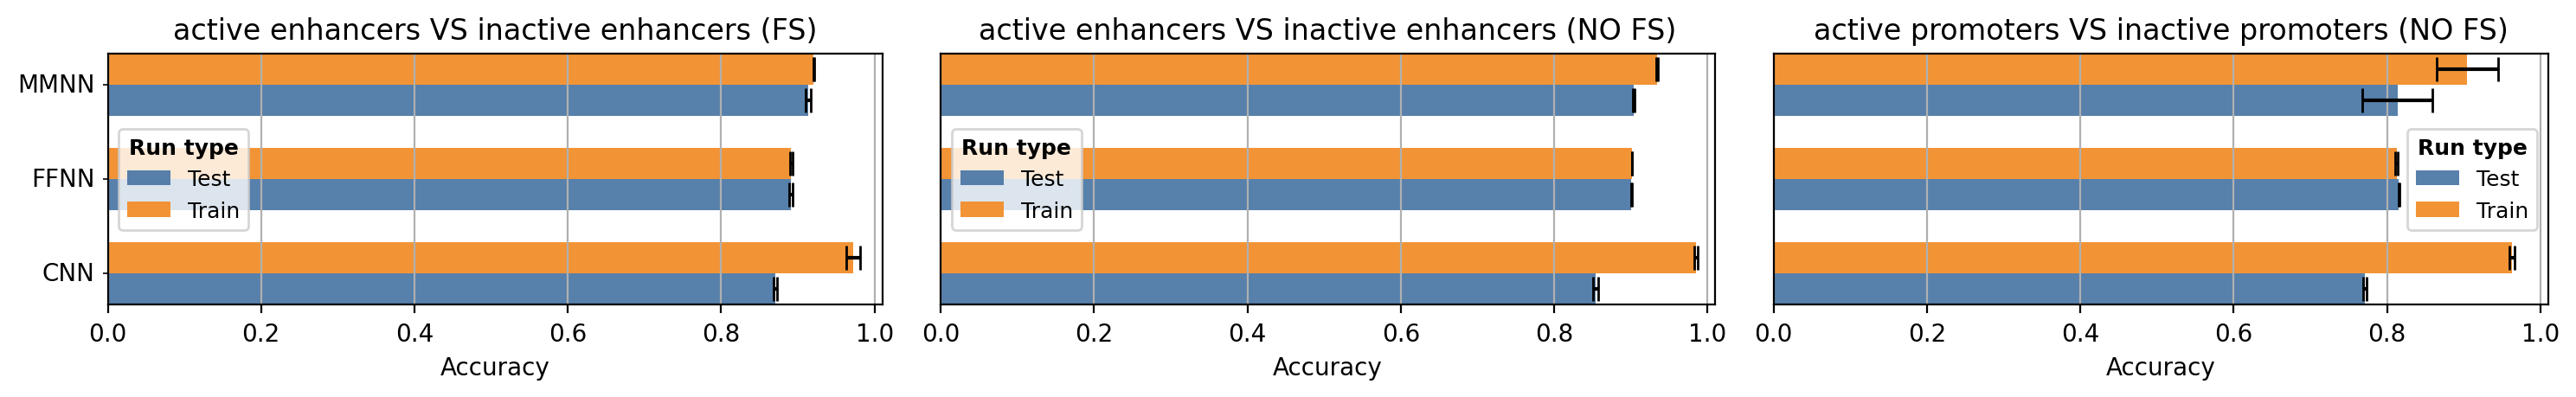

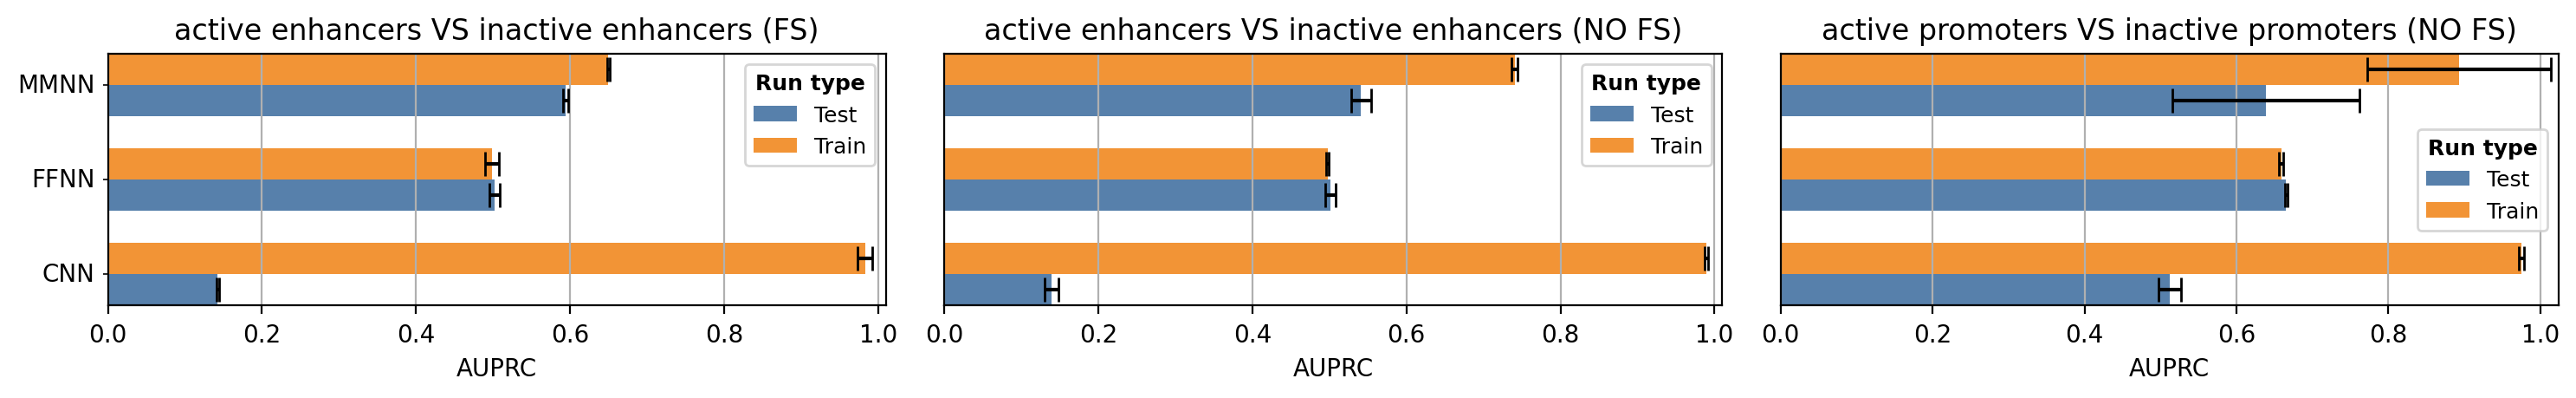

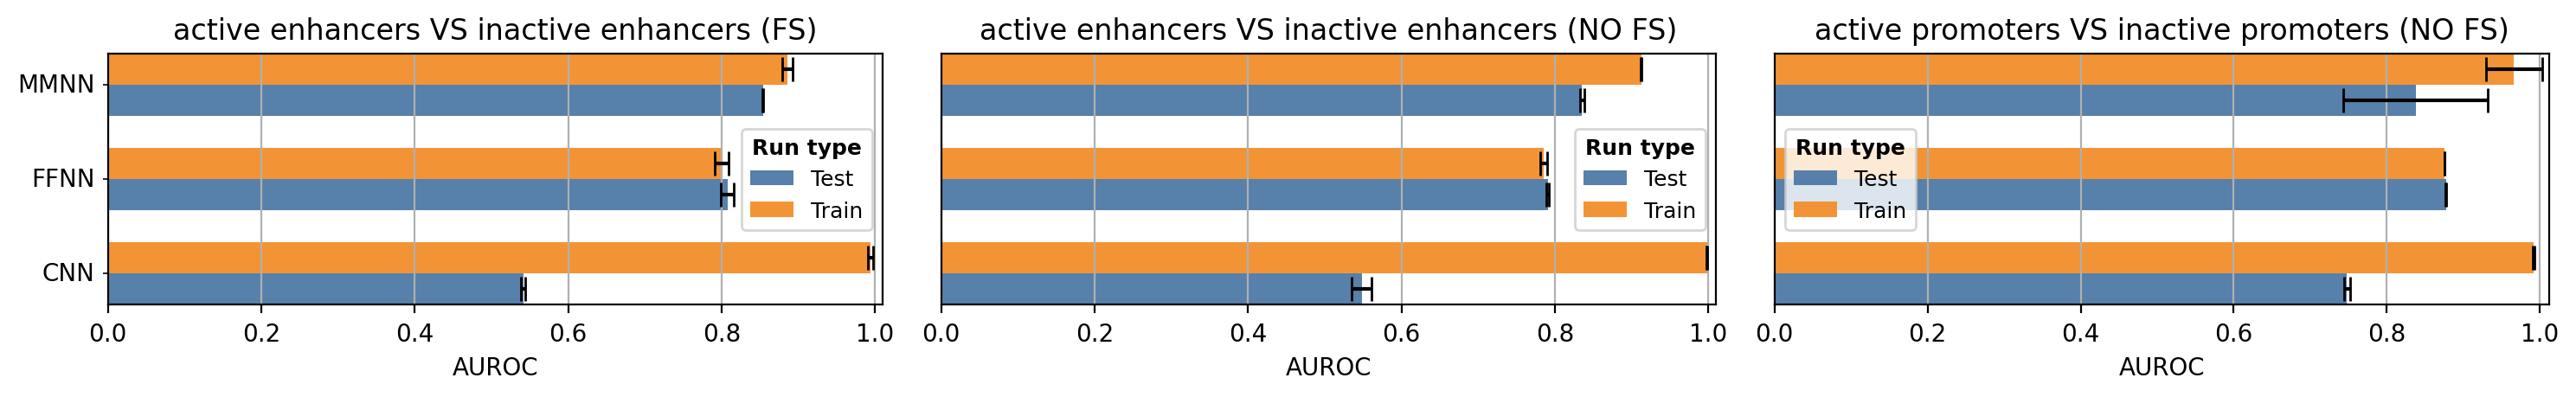

In [ ]:
barplots(
    df[[ 'AUPRC', 'AUROC','accuracy', "task", "model_name", "run_type"]],
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5,
    subplots=True,
    major_rotation=90
)

## Wilcoxon tests

In [ ]:
test_performance_aeie_fs = all_fixed_performance[ (all_fixed_performance.run_type=='test') & (all_fixed_performance.task == 'active_enhancers_vs_inactive_enhancers (FS)')]
test_performance_aeie_nofs = all_fixed_performance[ (all_fixed_performance.run_type=='test') & (all_fixed_performance.task == 'active_enhancers_vs_inactive_enhancers (NO FS)')]

In [ ]:
from scipy.stats import wilcoxon

ffnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='FFNN']
mmnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='MMNN']
cnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='CNN']
for (name1, name2), (df1, df2) in zip([ ('FFNN', 'CNN'), ('FFNN', 'MMNN'),  ('MMNN', 'CNN')], [ (ffnn_df, cnn_df), (ffnn_df, mmnn_df),  (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} accuracy ({np.mean(df1['accuracy'])}) and {name2} accuracy ({np.mean(df2['accuracy'])}): {wilcoxon( x = df1.accuracy, y = df2.accuracy)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on FFNN accuracy (0.8913249671459198) and CNN accuracy (0.8705854415893555): WilcoxonResult(statistic=0.0, pvalue=0.5)
 Wilcoxon test on FFNN auprc (0.5020849853754044) and CNN auprc (0.14273568242788315): WilcoxonResult(statistic=0.0, pvalue=0.5)
 Wilcoxon test on FFNN auroc (0.8074604570865631) and CNN auroc (0.5415753126144409): WilcoxonResult(statistic=0.0, pvalue=0.5)


 Wilcoxon test on FFNN accuracy (0.8913249671459198) and MMNN accuracy (0.9134865999221802): WilcoxonResult(statistic=0.0, pvalue=0.5)
 Wilcoxon test on FFNN auprc (0.5020849853754044) and MMNN auprc (0.5940822958946228): WilcoxonResult(statistic=0.0, pvalue=0.5)
 Wilcoxon test on FFNN auroc (0.8074604570865631) and MMNN auroc (0.8539848029613495): WilcoxonResult(statistic=0.0, pvalue=0.5)


 Wilcoxon test on MMNN accuracy (0.9134865999221802) and CNN accuracy (0.8705854415893555): WilcoxonResult(statistic=0.0, pvalue=0.5)
 Wilcoxon test on MMNN auprc (0.5940822958946228) and CNN auprc (0.14273568242